# iSR Standalone Test Notebook (GPU/CPU + Checkpoint Download + Inference)

This notebook is designed to be **standalone** for reviewers:
1. Detects **CPU/GPU** capabilities on the host machine
2. Installs dependencies (optional, if not already installed)
3. Downloads **model checkpoints** from the repository's Google Drive link
4. Runs a **minimal inference** with `infer.py` on a small sample input

> Expected checkpoint layout (from the repo README):
```
iSR/
├── checkpoints/BeatSaber/scale4Channels32.pth
└── checkpoints_SR/BeatSaber/scale4Channels48Block4.ckpt
```

In [1]:
from pathlib import Path
import os, sys, subprocess, platform

# If this notebook is run outside the repo, clone it automatically.
REPO_URL = "https://github.com/haseebfazal/iSR.git"

def ensure_repo_root() -> Path:
    cwd = Path.cwd()
    if (cwd / "infer.py").exists() and (cwd / "requirements.txt").exists():
        return cwd

    # If we're inside some workspace, try to find a parent containing infer.py
    for p in [cwd] + list(cwd.parents):
        if (p / "infer.py").exists() and (p / "requirements.txt").exists():
            os.chdir(p)
            return p

    # Otherwise, clone into a subfolder and chdir into it
    target = cwd / "iSR"
    if not target.exists():
        print(f"Cloning repo into: {target}")
        subprocess.run(["git", "clone", "--depth", "1", REPO_URL, str(target)], check=True)
    os.chdir(target)
    return target

repo_root = ensure_repo_root()
print("Repo root:", repo_root)
print("Python:", sys.version)
print("Platform:", platform.platform())

Cloning repo into: /home/haseeb/Downloads/iSR


Cloning into '/home/haseeb/Downloads/iSR'...


Repo root: /home/haseeb/Downloads/iSR
Python: 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
Platform: Linux-5.15.0-139-generic-x86_64-with-glibc2.31


In [2]:
# System capability checks: CPU, RAM, GPU (CUDA), and optional nvidia-smi output

import os, platform, shutil, subprocess
from datetime import datetime

def run_cmd(cmd):
    try:
        out = subprocess.check_output(cmd, stderr=subprocess.STDOUT, text=True)
        return out.strip()
    except Exception as e:
        return f"[command failed] {cmd}\n{e}"

print("Timestamp:", datetime.now().isoformat(timespec="seconds"))
print("\n=== CPU ===")
print("Processor:", platform.processor() or "N/A")
print("Machine:", platform.machine())
print("CPU cores (logical):", os.cpu_count())

try:
    import psutil
    vm = psutil.virtual_memory()
    print("\n=== Memory ===")
    print(f"Total RAM: {vm.total / (1024**3):.2f} GB")
    print(f"Available: {vm.available / (1024**3):.2f} GB")
    try:
        freq = psutil.cpu_freq()
        if freq:
            print("\n=== CPU Frequency ===")
            print(f"Current: {freq.current:.0f} MHz  (min={freq.min:.0f}, max={freq.max:.0f})")
    except Exception:
        pass
except ImportError:
    print("\n(psutil not installed; RAM stats skipped)")

print("\n=== GPU / CUDA (PyTorch) ===")
try:
    import torch
    print("torch:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("CUDA version (torch):", torch.version.cuda)
        n = torch.cuda.device_count()
        print("GPU count:", n)
        for i in range(n):
            print(f"  GPU[{i}]:", torch.cuda.get_device_name(i))
            props = torch.cuda.get_device_properties(i)
            print(f"    VRAM: {props.total_memory / (1024**3):.2f} GB")
    else:
        print("Running CPU-only mode is supported via --device cpu.")
except Exception as e:
    print("Torch import failed:", e)

print("\n=== nvidia-smi (if available) ===")
if shutil.which("nvidia-smi"):
    print(run_cmd(["nvidia-smi"]))
else:
    print("nvidia-smi not found (this is normal on CPU-only systems).")

Timestamp: 2026-02-26T21:18:01

=== CPU ===
Processor: x86_64
Machine: x86_64
CPU cores (logical): 16

=== Memory ===
Total RAM: 15.35 GB
Available: 8.67 GB

=== CPU Frequency ===
Current: 1044 MHz  (min=800, max=4600)

=== GPU / CUDA (PyTorch) ===
torch: 2.1.2+cu121
CUDA available: True
CUDA version (torch): 12.1
GPU count: 1
  GPU[0]: NVIDIA GeForce RTX 3060 Laptop GPU
    VRAM: 5.70 GB

=== nvidia-smi (if available) ===
Thu Feb 26 21:18:02 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |             

In [3]:
# (Optional) Install dependencies
# If you're already in a working environment, you can skip this cell.

import sys, subprocess
from pathlib import Path

req = Path("requirements.txt")
assert req.exists(), "requirements.txt not found — are you in the repo root?"

print("Installing requirements from:", req.resolve())
subprocess.run([sys.executable, "-m", "pip", "install", "-r", str(req)], check=True)

# gdown is used to download Google Drive files/folders
subprocess.run([sys.executable, "-m", "pip", "install", "gdown"], check=True)

print("Done installing.")

Installing requirements from: /home/haseeb/Downloads/iSR/requirements.txt



[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


Done installing.



[notice] A new release of pip available: 22.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
# Download checkpoints from Google Drive and place them into the expected folders.
# Google Drive folder link is referenced in the repo README.

from pathlib import Path
import shutil, sys, subprocess

GDRIVE_FOLDER_URL = "https://drive.google.com/drive/folders/12ruw5OJn9GsTKiljB9fHj_CVRkOfyqZF?usp=sharing"

expected_sic = Path("checkpoints/BeatSaber/scale4Channels32.pth")
expected_sr  = Path("checkpoints_SR/BeatSaber/scale4Channels48Block4.ckpt")

def already_ok():
    return expected_sic.exists() and expected_sr.exists()

def find_and_move(filename: str, dst: Path):
    matches = list(Path(".").rglob(filename))
    if not matches:
        return False
    src = matches[0]
    dst.parent.mkdir(parents=True, exist_ok=True)
    shutil.copy2(src, dst)
    print(f"Placed {filename} -> {dst}")
    return True

if already_ok():
    print("✅ Checkpoints already present:")
    print(" -", expected_sic)
    print(" -", expected_sr)
else:
    print("Downloading checkpoint folder from Google Drive...")
    # gdown folder download:
    # - It will create a directory named after the Drive folder (typically "iSR_Checkpoints")
    subprocess.run([sys.executable, "-m", "gdown", "--folder", GDRIVE_FOLDER_URL, "-O", "downloaded_checkpoints"], check=True)

    # Try to locate the exact filenames anywhere under downloaded_checkpoints and place them in the expected locations
    ok1 = find_and_move("scale4Channels32.pth", expected_sic)
    ok2 = find_and_move("scale4Channels48Block4.ckpt", expected_sr)

    if not (ok1 and ok2):
        print("\n⚠️ Could not auto-locate one or more checkpoint files after download.")
        print("Please inspect the downloaded directory:")
        print(" - downloaded_checkpoints/")
        print("and ensure the following are present:")
        print(" -", expected_sic)
        print(" -", expected_sr)
    else:
        print("✅ Checkpoints downloaded and placed correctly.")

print("\nFinal checkpoint status:")
print("SICNet:", expected_sic, "exists=" + str(expected_sic.exists()))
print("SR   :", expected_sr,  "exists=" + str(expected_sr.exists()))

✅ Checkpoints already present:
 - checkpoints/BeatSaber/scale4Channels32.pth
 - checkpoints_SR/BeatSaber/scale4Channels48Block4.ckpt

Final checkpoint status:
SICNet: checkpoints/BeatSaber/scale4Channels32.pth exists=True
SR   : checkpoints_SR/BeatSaber/scale4Channels48Block4.ckpt exists=True


In [5]:
# Run a minimal inference test (1 sample image) using infer.py

from pathlib import Path
import shutil, sys, subprocess

infer_py = Path("infer.py")
assert infer_py.exists(), "infer.py not found — are you in the repo root?"

# Pick 1 sample input image
default_dir = Path("Example_images/X4_stitch")
assert default_dir.exists(), "Example_images/X4_stitch not found (repo content changed?)"

pngs = sorted(default_dir.glob("*.png"))
assert pngs, f"No PNGs found in {default_dir}"

mini_in = Path("_mini_input")
mini_in.mkdir(exist_ok=True)
sample = pngs[0]
shutil.copy2(sample, mini_in / sample.name)

out_dir = Path("_mini_results")
out_dir.mkdir(exist_ok=True)

# Choose device automatically: cuda if available else cpu
device = "cpu"
try:
    import torch
    if torch.cuda.is_available():
        device = "cuda"
except Exception:
    pass

sic = Path("checkpoints/BeatSaber/scale4Channels32.pth")
sr  = Path("checkpoints_SR/BeatSaber/scale4Channels48Block4.ckpt")
assert sic.exists(), f"Missing checkpoint: {sic}"
assert sr.exists(),  f"Missing checkpoint: {sr}"

cmd = [
    sys.executable, "infer.py",
    "--input_dir", str(mini_in),
    "--out_dir", str(out_dir),
    "--sicnet_ckpt", str(sic),
    "--sr_ckpt", str(sr),
    "--device", device,
    "--overwrite",
]
print("Running:", " ".join(cmd))
subprocess.run(cmd, check=True)

print("\n✅ Inference completed.")
print("Outputs written to:", out_dir.resolve())
print("Output files:")
for p in sorted(out_dir.rglob("*")):
    if p.is_file():
        print(" -", p)

Running: /home/haseeb/anaconda3/bin/python infer.py --input_dir _mini_input --out_dir _mini_results --sicnet_ckpt checkpoints/BeatSaber/scale4Channels32.pth --sr_ckpt checkpoints_SR/BeatSaber/scale4Channels48Block4.ckpt --device cuda --overwrite


/home/haseeb/anaconda3/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


[config] device=cuda  input=/home/haseeb/Downloads/iSR/_mini_input  output=/home/haseeb/Downloads/iSR/_mini_results
[ok] Loaded SICNet from checkpoints/BeatSaber/scale4Channels32.pth
gamma
head.0.weight
head.0.bias
convlstm.conv_f.weight
convlstm.conv_f.bias
convlstm.conv_i.weight
convlstm.conv_i.bias
convlstm.conv_o.weight
convlstm.conv_o.bias
convlstm.conv_c.weight
convlstm.conv_c.bias
hfb.0.rep_conv.weight
hfb.0.rep_conv.bias
body.0.conv1.rep_conv.weight
body.0.conv1.rep_conv.bias
body.0.norm.weight
body.0.norm.bias
body.1.conv1.rep_conv.weight
body.1.conv1.rep_conv.bias
body.1.norm.weight
body.1.norm.bias
body.2.conv1.rep_conv.weight
body.2.conv1.rep_conv.bias
body.2.norm.weight
body.2.norm.bias
body.3.conv1.rep_conv.weight
body.3.conv1.rep_conv.bias
body.3.norm.weight
body.3.norm.bias
tail.0.weight
tail.0.bias
conv_main_scale.0.weight
conv_main_scale.0.bias
conv_skip_scale.0.weight
conv_skip_scale.0.bias
[ok] Loaded SR model from checkpoints_SR/BeatSaber/scale4Channels48Block4.ckp

Displaying: _mini_results/00101_SBS_colorized.png


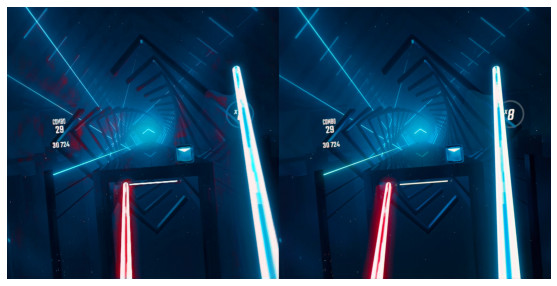

In [6]:
# Visualize an output image (if any PNGs were produced)

from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

out_dir = Path("_mini_results")
pngs = sorted(out_dir.rglob("*.png"))

if not pngs:
    print("No PNG outputs found to display. Listing files instead:")
    for p in sorted(out_dir.rglob("*")):
        if p.is_file():
            print(" -", p)
else:
    img_path = pngs[0]
    print("Displaying:", img_path)
    img = Image.open(img_path)
    plt.figure(figsize=(10, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()